In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nine-language-xfact/x_fact_test_clean_9L.csv
/kaggle/input/nine-language-xfact/x_fact_train_oversampled_9L.csv


In [2]:
!pip install transformers datasets torch scikit-learn

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [4]:
test_df = pd.read_csv("/kaggle/input/nine-language-xfact/x_fact_test_clean_9L.csv")

print("Test Data Sample:\n", test_df.head())

label_encoder = LabelEncoder()
test_df["label"] = label_encoder.fit_transform(test_df["label"])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping:", label_mapping)

test_texts = test_df["claim"].tolist()
test_labels = test_df["label"].tolist()
num_labels = len(set(test_labels))


Test Data Sample:
                                                claim         label  \
0  Anton Hofreiter: „Wir können kriminelle Flücht...         false   
1  Skok (na Trybunał Konstytucyjny - przyp. Demag...  mostly false   
2  2017’de tarımsal kesime 12,7 milyar lira deste...          true   
3  Eşcinseller kan verme konusunda risk grubundad...         false   
4  წელს, 2015 წელთან შედარებით, საქართველოს აეროპ...          true   

  source_language  
0              de  
1              pl  
2              tr  
3              tr  
4              ka  

Label Mapping: {'false': 0, 'mostly false': 1, 'mostly true': 2, 'true': 3}


In [5]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(
        texts, 
        truncation=True,
        padding="max_length",  
        max_length=512,
        return_tensors="pt"
    )

test_encodings = tokenize_function(test_texts)

test_labels_tensor = torch.tensor(test_labels)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32  
).to(device)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
batch_size = 8  

test_dataset = TensorDataset(
    test_encodings["input_ids"], 
    test_encodings["attention_mask"], 
    test_labels_tensor
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Run inference in batches
model.eval()
all_predictions, all_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")

print("\n **Baseline Model Performance (`xlm-roberta-base`)**")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")



 **Baseline Model Performance (`xlm-roberta-base`)**
Accuracy: 0.3184
F1-score: 0.1538
Recall: 0.3184


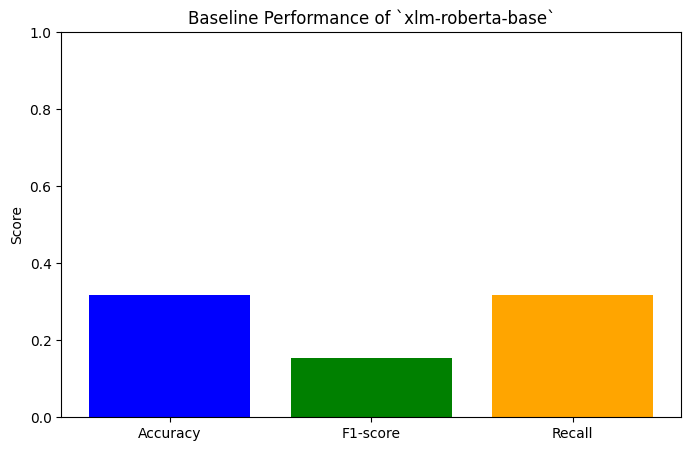

In [8]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "F1-score", "Recall"]
values = [accuracy, f1, recall]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=["blue", "green", "orange"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Baseline Performance of `xlm-roberta-base`")
plt.show()
